# Time Series Analysis

## Introduction

A time series is simply the series of periodic observations of a random variable $X$ depending on time $t$ ($X_t$) over a set of subsequent moments of time $t=1,...,T$ (or $t=1,2,...$ for $T=\infty$):
$$
\{x_t, t=1,...,T\}.
$$
Examples include daily (or hourly or 15/5/1 min) stock prices, weather observations, noise level on the street changing over time, daily/hourly traffic counts, taxi ridership etc.


We assume that there is a certain consistent Data Generating Process behind those observations.
A set of random variables $X_t$ generating a time-series observations is called a stochastic process.

Time increments could be a month, a day, an hour, minute, second, or something smaller.

Typically unless specified otherwise, assume that variables $X_t$ and their observations $x_t$ are real-valued and one-dimentional, however discrete or multidimensional values are also considered in general. 

Goals of time-series analsys are threfold:

#### pattern recognition
(signal detection, financial trends, weekly activity patterns, anomaly detection etc)

#### predictive modelling
(stock prices prediction, weather forecast etc)

#### classification
(land use classification based on timeline of human activity, letter identification based on a series of hand movements, etc)


### Key Topics in Time Series Analysis

#### 1. Exploratory analysis. Trend detection and detrending. Interpretation.
are there consistent upward or downward patterns in the time-series (trends)? seasonal variations? what are the properties of the residual time-series after all recognizeable temporal patterns are removed? 
#### 2. Forecasting. Serial dependence
are there significant correlations between time-adjacent observations? can we model those?
#### 3. Simulation
based on our knowledge of the time-series patterns and process behind them, estimate probability of certain outcomes through multiple simulations of the process.
#### 4. Control
what is the impact of certain actions on the time-series?
#### 5. Hypothesis testing
prove significance of the hypothesized patterns behind observed time-series.
#### 6. Stationarity 
does the time-series remain stable over time? would it diverge to $\pm \infty$ in finite time? 

### Important particular cases of time-series

#### 1. White noise
the process generating values at different moments of time is independent of time and other observations
#### 2. AR,MA,ARMA, ARIMA processes
different combinations of white noise into more sophisticated and applied processes with temporally related observations
#### 3. Random walk process
sequentially modifying single or multi-dimensional variable over time using temporally independent steps (accumulating white noise over time)
#### 4. Markov process (Markov chain)
discrete time-series with limited depth of temporal dependence

In [49]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import Quandl
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

(0, 7)

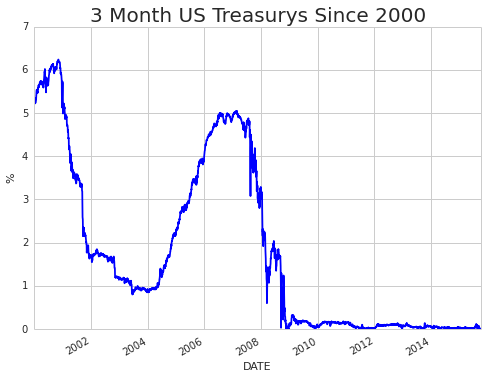

In [2]:
#Examples of time-series - financial instrument rates changing over time
start_date = "2000-01-01"
end_date = "2015-10-10"
tbill3Q = Quandl.get("FRED/DTB3", trim_start=start_date, trim_end=end_date)
tbond10Q = Quandl.get("FRED/DGS10", trim_start=start_date, trim_end=end_date)

tbill3 = tbill3Q['VALUE']
tbond10 = tbond10Q['VALUE']
plt.figure(figsize = (8, 6))
tbill3.plot(color = 'blue')
plt.title('3 Month US Treasurys Since 2000', fontsize=20)
plt.ylabel('%')
plt.ylim(0,7)

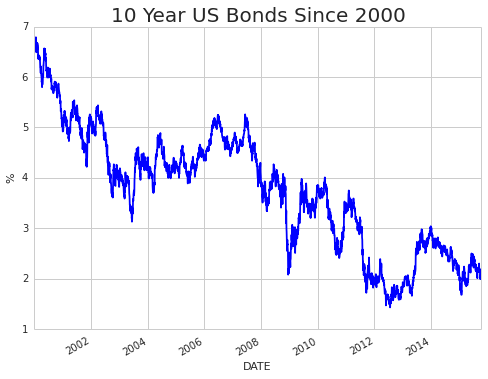

In [3]:
plt.figure(figsize = (8, 6))
tbond10.plot(color = 'blue')
plt.title('10 Year US Bonds Since 2000', fontsize=20)
plt.ylabel('%')

## 1. Basic exploratory analysis. 

In a simplest interpretation time-series could be thought as a uni-variate regression model
$$
X_t=f(t)+Y_t,
$$
where $f(t)$ incorporates impact of time (trend component) and $Y_t$ is a residual with zero mean $E[Y_t]=0$ and distribution independent on $t$ (also called IID-noise or in case of a normal distribution - white noise). 

In case of a suggested linear trend $f(t)=w_0 + w_1 t$ and normal distribution assumed for the residual, this becomes a simple bi-variate linear regression. If $f$ is polynomial the problem could be also considered as a multi-variate linear regression over powers of $t$, i.e. $t,t^2,...$.

Instead of improsing specific analytic shape for $f$ we can also try to directly observe it applying a moving-average smoothing over the data:
$$
ma^-(l)_t=\frac{\sum\limits_{j=-l+1}^0 x_j}{l},
$$
or 
$$
ma^\pm(l)_t=\frac{\sum\limits_{j=-l+1}^{l-1} x_j}{2l+1},
$$
where $l$ is the temporal lag; or more generally 
$$
ma^-(l)_t=\sum\limits_{j=-l+1}^0 w_j x_j,
$$$$
ma^\pm(l)_t=\sum\limits_{j=-l+1}^{l-1} w_j x_j,
$$
where $w_j$ are the normalized weights, such that $\sum\limits_j w_j=1$.

#### Refer to R example for the real estate prices.

## 2. Time-series model

A time-series model is a specification of all the joint distributions
$$
P(X_t\leq x_t, t=1..T).
$$
Considering an infinite time-series $X_t$ for unlimied $t$ (a stochastic process) the modelling is to specify all the joint distributions
$$
P(X_t\leq x_t, t=1..n)
$$
for all finite $n$.

### 2.1. IID and white noise

If variables $X_t$ are independent and identically distributed the time-series is called IID. 

If variables $X_t$ are binary random variables (following Bernoulli distribution $X_t\sim Bern(p)$) then the IID time-series is called binary.

The IID time-series with normally distributed $X_t$ is called white noise.

### 2.2. Random walk
Random walker process is the time-series (stochastic process), such that 
$$
X_t=X_{t-1}+Y_t
$$
where $Y_t$ is IID. $Y_t$ and $X_t$ could be discrete or continous real-valued; can be also multi-dimensional.

### 2.3. Stationarity and autocorrelation
Stochastic process is called stationary if its statistical properties do not change over time. The strong stationarity 
means that all the joint distributions
$$
P(X_{t_1+\tau}\leq x_\tau, \tau=0..n)=P(X_{t_2+\tau}\leq x_\tau, \tau=0..n)
$$
do not depend on the specific choice of the initial moment of time $t_1$ or $t_2$.

A more practical definition of the weak stationarity is about having constant mean
$$
E[X_t]=\mu
$$
and having covariation between each two variables $Cov(X_{t_1},X_{t_2})$ in two moments of time $t_1$ and $t_2$ being finite and only depending on the time lag $t_2-t_1$ but not on the spefic moment $t_1$ or $t_2$, i.e.
$$
Cov(X_{t},X_{t+\tau})=Cov(X_{t^*},X_{t^*+\tau})=\gamma(\tau),
$$
where $\gamma$ is a certain symmetric non-negative-valued function of a time lag $\tau$: $\gamma(-\tau)=\gamma(\tau)>0$. $\gamma$ is called autocovariance function. In particular from the above it follows that
$$
Var[X_t]=\gamma(0)=const,
$$
i.e. not only mean, but also variance of all variables $X_t$ is constant. Then autocorrelation function could be defined as
$$
\rho(\tau)=corr(X_t,X_{t+\tau})=\frac{Cov(X_t,X_{t+\tau})}{\sqrt{Var[X_t]Var[X_{t+\tau}]}}=\frac{\gamma(\tau)}{\gamma(0)}
$$
In particular, IID is certainly stationary with 
$$
\rho(\tau)=\left\{\begin{array}{c}1,\ \tau=0,\\0,\ \tau\neq 0.\end{array}\right.
$$  
However stationary time-series are not necessary IID - further we'll consider more sophisticated cases widely applied in finance and other fields. 

Random walk however is not stationary.

Stationarity is an important concept for time-series analysis as stationary processes possess many properties useful for analysis, while for non-stationary processes the objective of the analysis is often seen to transform them to the stationary form (chase for stationarity) - refer to classical decomposition for example.

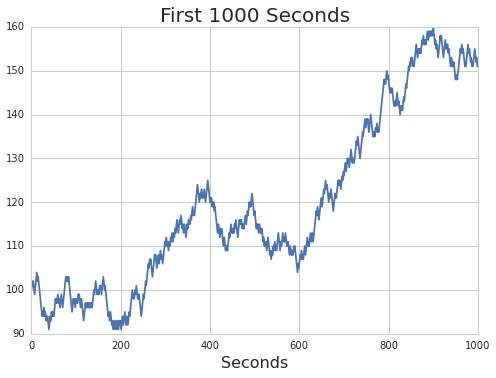

In [27]:
# Simple Application 1: A Random Walk.

# Set an arbitrary starting point and iterate the system using a simple Markov process.
# Each second, this Markov process can move up 1 or it can move down, which it does at random.
# Pr(up) = Pr(down) = 0.5.

# pos is starting position.
# draws are random integers, {0, 1}.
# step is -1 if random draw is 0 and +1 if random draw is 1.
# walk is the vector containing each step.

random.seed(1234)

pos = 100  
walk = [pos] # walk is the array that tracks the random path
nsteps = 10000 # establishs number of random steps
for i in range(nsteps):
    step = 1 if np.random.randint(0, 2) else -1 # Bernoulli draw to step "up" or "down"
    pos += step
    walk.append(pos)

plt.plot(walk[0:1000])
plt.title('First 1000 Seconds', fontsize=20)
plt.xlabel('Seconds', fontsize=16)

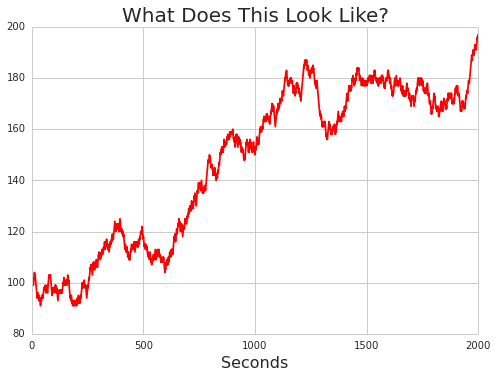

In [32]:
plt.plot(walk[0:2000], 'r')
plt.title("What Does This Look Like?", fontsize=20)
plt.xlabel('Seconds', fontsize=16)

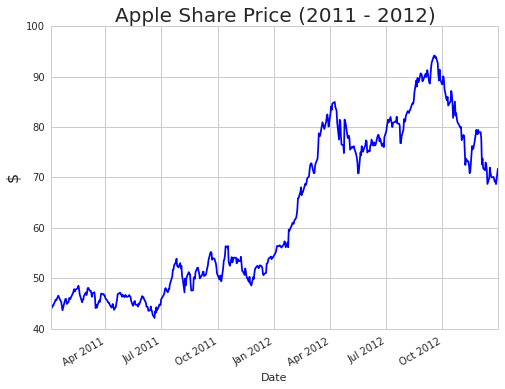

In [6]:
aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2011-1-1", trim_end="2013-1-1")
aapl = aapl_all['Adjusted Close']

plt.figure(figsize = (8, 6))
aapl.plot(color = 'blue')
plt.title('Apple Share Price (2011 - 2012)', fontsize=20)
plt.ylabel('$', fontsize=16)

In [47]:
# Simple Application 2: A Drunken Sailor on a Mountaintop

random.seed(2016)
edge = 100
nsteps = 10000

pos1, pos2 = 0, 0  
walk1, walk2 = [pos1], [pos2] 
for i in range(nsteps):
    step1 = 1 if np.random.randint(0, 2) else -1 
    step2 = 1 if np.random.randint(0, 2) else -1
    pos1 += step1
    pos2 += step2
    if np.abs(pos1) > 100 or np.abs(pos2) > 100:
        print("Sailor fell off the moutain at coordinates", pos1, pos2, "on step", i)
        break
    walk1.append(pos1)
    walk2.append(pos2)

('Sailor fell off the moutain at coordinates', -49, 101, 'on step', 4432)


(-100, 100)

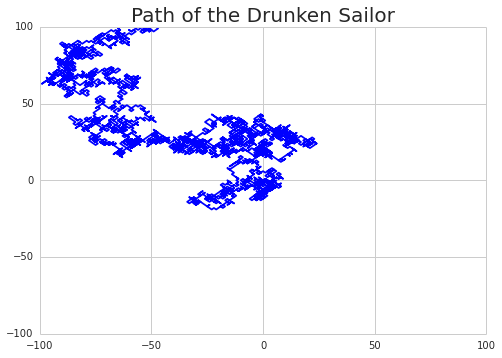

In [48]:
plt.plot(walk1, walk2, 'b')
plt.title("Path of the Drunken Sailor", fontsize=20)
plt.xlim(-edge, edge)
plt.ylim(-edge, edge)

## 3. Seasonality and classical decomposition 
A classical decomposition of a time-series $X_t$ is 
$$
X_t=m_t+s_t+Y_t,
$$
where $m_t$ is the function of $t$, responsible for systematic change of $X$ over time (trend component), $s$ is a periodic function of $t$ (seasonal component) with a known period $d$, such that $s_{t+d}=s_t$ and $\sum_{j=0}^{d-1}s_t=0$, and $Y$ is a stationary time-series. 

Often $s$ represents an annual, weekly or daily variation. Of course not any arbitrary time-series could be represented this way but looking for such representation in a hope for stationarity of residuals $Y_t$ is the goal of classical exploratory analysis.

More generally $s_t$ could be a sum of several periodic functions $s_t=\sum_k s^k_t$ with different periods $d^k$. This allows to account for an overlapping combination of different seasonal variations, such as weekly and daily ones together.

If seasonality period $d$ is known then moving average smoothing with the lag being a factor of $d$ eliminates seasonal component $s_t$ also reducing the relative impact of the residuals (as the variance of an average of $n$ residuals decrease proportionally to $n$) - this was the trend component $m_t$ could be estimated. 

Then once the trend component is removed ($X_t-m_t$) one can focus on estimating $s_\tau, \tau=0..d$ as sample means of the corresponding available observations
$$
s_\tau=\frac{\sum\limits_k x_{k d+\tau}}{|\{k\}|},
$$
since $E[Y_t]=0$.

But what if we do not have a good idea of what the periods could be? Spectral decomposition though Fourier transform technique could help with that. We won't focus too much on the theory and computational approach here.
Both R and python have ready to use tools of estimating this decomposition given the time-series observations (Fast Fourier Transform) as well as estimating the relative strength of different possible periods $d_k$ (periodigram) allowing to pick up the one or several ones, most consistent with the observations. 

#### Refer to R example for the taxi ridership analysis.

In [9]:
import statsmodels.api as sm
dta = sm.datasets.co2.load_pandas().data
dta.co2.interpolate(inplace=True)
dta.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


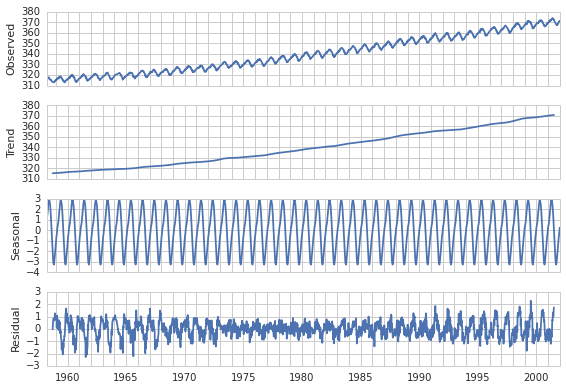

In [12]:
res = sm.tsa.seasonal_decompose(dta)
resplot = res.plot()

## 4. Advanced time-series models 


### 4.1. Moving average process MA(p)
A simple generalization of white noise process is considering it's moving averages
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}.
$$

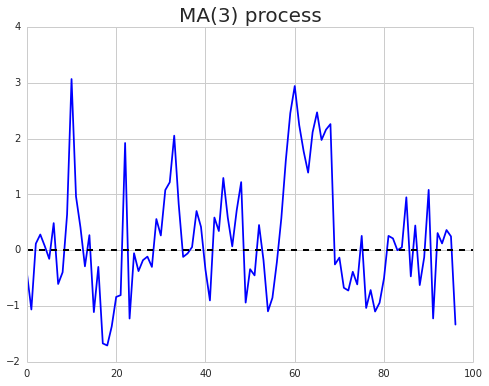

In [13]:
T = 100
p=3
#generating and visualizing MA(3) process
theta=[1, 0.5, 0.3, 0.2]
random.seed(2014)
y=np.random.normal(0, 1, T)
x=0
for k in range(0,p+1):
    x=x+theta[k]*y[range(p-k,T-k)]
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title('MA(3) process', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

### 4.2. Autoregressive Processes AR(q)
This process would model the rule that "Today is mostly yesterday plus a little noise."
We can write the AR(1) process as follows: 
$$
X_t = \rho X_{t-1} + Y_t
$$ 
In case $\rho=1$ this is a random walk process.  

For $|\rho|<1$ this process is stationary and

$\displaystyle {Cov(X_t, X_{t-1})= E(X_t \cdot X_{t-1}) = \frac{\rho}{1-\rho^2}}$

Indeed, for any $k$,

$\displaystyle {Cov(X_t, X_{t-k})= \frac{\rho^k}{1-\rho^2}}$

More importantly, since correlation is defined as covariance divided by variance, for any AR(1) process, $y_t$, 
the "autocorrelation" function is simply:

$\displaystyle {Corr(X_t, X_{t-k})= \rho^k}$

Here, autocorrelation simply means "correlated with itself through time".

Therefore, in summary, the AR(1) process, $X_t$, has the following characteristics:

1. Zero mean.
2. Finite variance.
3. Autocorrelation function that decays geometrically, $\rho^k$, over $k$ periods.  Note that for $k=0$, correlation is 1 (as it should be).

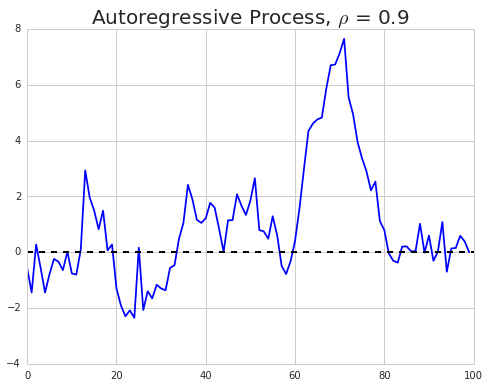

In [14]:
random.seed(2014)
#generating and visualizing AR(1) process
T = 99
rho = 0.9
x = np.zeros(T+1)

x[0] = np.random.normal(0, 1)

for t in range(1, T):
    x[t] = rho * x[t-1] + np.random.normal(0, 1)

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

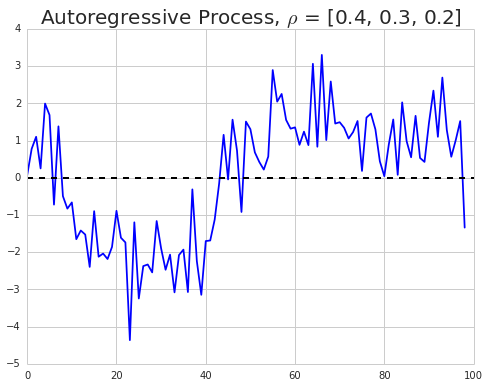

In [15]:
random.seed(2011)
#generating and visualizing AR(3) process
T = 99
rho = [0.4, 0.3, 0.2]
x = np.zeros(T+1)

x = np.random.normal(0, 1, 3)

for t in range(3, T):
    x=np.append( x, rho [0] * x[t-1] + rho [1] * x[t-2] + rho [2] * x[t-3] + np.random.normal(0, 1))

r = rho
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
#plt.ylim(-4, 4)
plt.title(r'Autoregressive Process, $\rho$ = %r' %(r), fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

Now further generalizing AR(q):
$$
X_t = \sum_{j=1}^q \rho_j X_{t-j} + Y_t.
$$

### 4.3. ARMA(p,q)
Combining both together
$$
X_t = Y_t+\sum_{j=1}^p \theta_j Y_{t-j}+\sum_{j=1}^q \rho_j X_{t-j}.
$$

In [20]:
"""
Random generation of Gaussian ARMA(p,q) time series from http://stats.stackexchange.com/questions/37437/random-generation-of-arma2-2-gaussian-time-series

INPUTS

phi:      An array of length p with the AR coefficients (the AR part of 
          the ARMA model).

theta:    An array of length q with the MA coefficients (the MA part of 
          the ARMA model).

sigma:    Standard deviaton of the Gaussian noise.

n:        Length of the returned time-series.

burnin:   Number of datapoints that are going to be discarded (the higher 
          the better) to avoid dependence of the ARMA time-series on the 
          initial values.
""" 

from numpy.random import normal
from numpy import *
def ARMAgenerator(phi,theta,sigma,n,burnin=0,verbose=0):
    l=max(len(phi),len(theta))
    if(burnin==0):
      burnin=10*l # Burn-in elements!
    w=normal(0,sigma,n+burnin)
    ARMA=array([])
    s=0.0
    l=max(len(phi),len(theta))
    for i in range(n+burnin):
        if(i<l):
          ARMA=append(ARMA,w[i])
        else:
          s=0.0
          for j in range(len(phi)):
              s=s+phi[j]*ARMA[i-j-1]
          for j in range(len(theta)):
              s=s+theta[j]*w[i-j-1]
          ARMA=append(ARMA,s+w[i])
    if(verbose!=0):
      print 'Measured standard deviation: '+str(sqrt(var(w[burnin:])))
    return ARMA[burnin:]

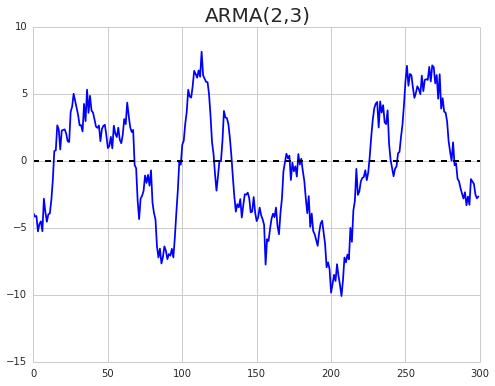

In [21]:
random.seed(2011)
x=ARMAgenerator([0.5, 0.4],[0.4,0.3,0.2],1,300)
plt.figure(figsize = (8, 6))
plt.plot(x, 'b')
plt.title(r'ARMA(2,3)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

### 4.4. ARIMA(p,q,r)
Now ARIMA is a discrete integration of ARMA. If 
$$
\nabla X_t=X_t-X_{t-1}=Y_t \sim ARMA(p,q)
$$
then process $\{X_t\}\sim ARIMA(p,q,1)$. Similarly if 
$$
\nabla X_t\sim ARIMA(p,q,1),
$$
i.e. 
$$
\nabla^2 X_t\sim ARMA(p,q)
$$ 
then $\{X_t\}\sim ARIMA(p,q,2)$. Finally we say $\{X_t\}\sim ARIMA(p,q,r)$ if
$$
\nabla^r X_t\sim ARMA(p,q).
$$ 

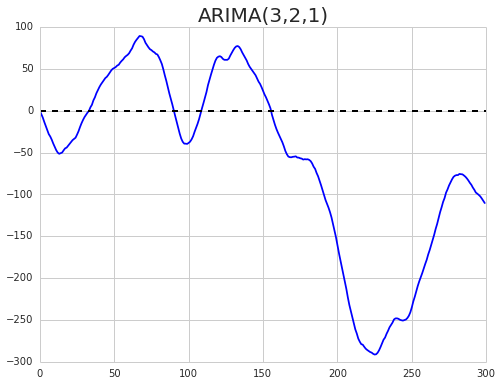

In [22]:
T = 300
x1=[0]
for t in range(1, T):
    x1=np.append( x1, x1[t-1] + x[t])

plt.figure(figsize = (8, 6))
plt.plot(x1, 'b')
plt.title(r'ARIMA(3,2,1)', fontsize=20)
plt.axhline(0, color='k', ls='--', lw=2)

## 5. Markov process

A Markov process (Markov chain) $\{X_t\}$ is a stochastic process with discrete outcomes with the property that, 
given the outcome of $X_t$, the outcome of $X_{t+1}$ is no further affected by the previous outcomes of 
$\{X_u\}$ for $u < t$.  Therefore, $Pr(X_{t+1} \big| X_t, X_{t-1}, ...) = Pr(X_{t+1} \big| X_t)$.

Then the process is fully described by probabilities $p_{ij}(t)=P(X_{t+1}=j|X_t=i)$ of transitioning from state i to state j at the moment $t$. If those probabilities do not depend on $t$ they are called stationary (do not confuse with the definition of stationary process).

So knowing current state of the system is all we need in order to predict its further states (prediction is not deterministic but probabilistic, however current state of the system gives all necessary information for it).

In [50]:
# Let's apply this to something non-deterministic using a NYC Subway rat.
# If on Track A, Pr(stays) = 1/2 and Pr(moves to B) = 1/2
# If on Track B, Pr(stays) = 1/2, Pr(move to A) = 1/4, and Pr(moves to C) = 1/4
# If on Track C, Pr(stays) = 1/2 and Pr(moves to C) = 1/2

print("A Rat in a NYC Subway Tunnel")
table = [[" ", "Track A", "Track B", "Track C"],
        ["Track A", "1/2", "1/2", "0"],
        ["Track B", "1/4", "1/2", "1/4"],
        ["Track C", "0", "1/2", "1/2"],]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

MT = np.matrix('0.5 0.5 0; 0.25 0.5 0.25; 0 0.5 0.5')
print("As an Numpy matrix")
print(MT)

A Rat in a NYC Subway Tunnel
╒═════════╤═════════╤═════════╤═════════╕
│         │ Track A │ Track B │ Track C │
├─────────┼─────────┼─────────┼─────────┤
│ Track A │ 1/2     │ 1/2     │ 0       │
├─────────┼─────────┼─────────┼─────────┤
│ Track B │ 1/4     │ 1/2     │ 1/4     │
├─────────┼─────────┼─────────┼─────────┤
│ Track C │ 0       │ 1/2     │ 1/2     │
╘═════════╧═════════╧═════════╧═════════╛
()
As an Numpy matrix
[[ 0.5   0.5   0.  ]
 [ 0.25  0.5   0.25]
 [ 0.    0.5   0.5 ]]


In [55]:
# On which track do you want to place the rat in the initial time period?

rat = np.matrix('0 1 0')
# Now iterate the rate through time.
# The future location of the rat is inherently probabilistic (like electrons).

for i in range(1, 11):
    print('Probability rat in on Track A, B, or C at time t + %i' % (i))
    print(rat * np.linalg.matrix_power(MT, i))
    print()

Probability rat in on Track A, B, or C at time t + 1
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 2
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 3
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 4
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 5
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 6
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 7
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 8
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 9
[[ 0.25  0.5   0.25]]
()
Probability rat in on Track A, B, or C at time t + 10
[[ 0.25  0.5   0.25]]
()
